📥 Download dati da Yahoo Finance: BTC-USD...

📊 PROFESSIONAL TRADING REPORT - RISK ANALYSIS
DATI STORICI:
  • Numero Operazioni:        8
  • Max Loss Storica (unit):  $17,498.48
  • Capitale Disponibile:     $100,000.00
-----------------------------------------------------------------
🚀 PROFILO: MATEMATICO PURO (Optimal F)
  • Leva Ottimale (f):        49.18%
  • Rischio Monetario:        $49,180.00
  • SIZE SUGGERITA:           2 contratti
-----------------------------------------------------------------
🏛️  PROFILO: ANZIANO (Professional 10%)
  • Rischio Monetario:        $10,000.00
  • SIZE SUGGERITA:           1 contratti



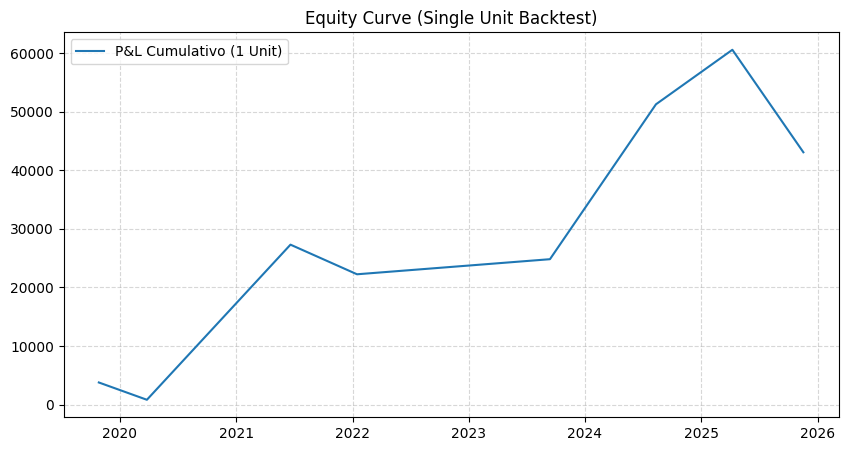

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import warnings

# Disabilita warning per pulizia output
warnings.filterwarnings("ignore")

# ==============================================================================
# 1. MODULO MATEMATICO (Risk Management Solver)
# ==============================================================================

def solve_optimal_f(pnl_series):
    """
    Risolutore matematico per la Frazione Ottimale (Ralph Vince).
    Indipendente da qualsiasi architettura proprietaria.
    """
    if pnl_series is None or len(pnl_series) < 2:
        return 0.0

    trades = np.array(pnl_series)
    max_loss = abs(min(trades))

    if max_loss == 0: return 0.0

    # Funzione di massimizzazione TWR (Terminal Wealth Relative)
    def objective_function(f):
        # TWR = PROD(1 + f * (-Trade / MaxLoss))
        # Minimizziamo il negativo del logaritmo per stabilità
        relative_returns = 1 + f * (trades / max_loss)
        if np.any(relative_returns <= 0): return 1e10 # Penalità "Rovina"
        return -np.sum(np.log(relative_returns))

    res = minimize_scalar(objective_function, bounds=(0.01, 0.99), method='bounded')
    return round(res.x, 4)

# ==============================================================================
# 2. MOTORE DI BACKTESTING (Generic Vector/Loop)
# ==============================================================================

def run_simple_backtest(df, initial_capital=100000):
    """
    Motore generico per strategie trend-following.
    """
    open_pos = False
    entry_price = 0.0
    entry_date = None
    trades = []

    # Equity curve partendo dal capitale
    equity_curve = [initial_capital]

    # Loop semplice sulle barre
    for i in range(1, len(df)):
        # -- Logica di Ingresso --
        if not open_pos and df['signal'].iloc[i-1] == 1:
            open_pos = True
            entry_price = df['Open'].iloc[i]
            entry_date = df.index[i]

        # -- Logica di Uscita --
        elif open_pos and df['signal'].iloc[i-1] == -1:
            open_pos = False
            exit_price = df['Open'].iloc[i]

            # Calcolo P&L su 1 unità (contratto/azione)
            pnl = (exit_price - entry_price)

            trades.append({
                'entry_date': entry_date,
                'exit_date': df.index[i],
                'operations': pnl  # Profitto/Perdita monetaria
            })

    return pd.DataFrame(trades)

# ==============================================================================
# 3. LOGICA STRATEGIA & DATI (Standard SMA Crossover)
# ==============================================================================

def get_market_data(ticker, start_date):
    print(f"📥 Download dati da Yahoo Finance: {ticker}...")
    df = yf.download(ticker, start=start_date, progress=False)

    # Gestione MultiIndex di yfinance (fix versioni recenti)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # --- Definizione Strategia Basilare (Golden Cross) ---
    df['FastSMA'] = df['Close'].rolling(window=50).mean()
    df['SlowSMA'] = df['Close'].rolling(window=200).mean()

    df['signal'] = 0
    # Long se Fast taglia Slow dal basso verso l'alto
    df.loc[(df['FastSMA'] > df['SlowSMA']) & (df['FastSMA'].shift(1) <= df['SlowSMA'].shift(1)), 'signal'] = 1
    # Exit se Fast taglia Slow dall'alto verso il basso
    df.loc[(df['FastSMA'] < df['SlowSMA']) & (df['FastSMA'].shift(1) >= df['SlowSMA'].shift(1)), 'signal'] = -1

    return df.dropna()

# ==============================================================================
# 4. REPORTISTICA AVANZATA (Optimal F + Profilo Anziano)
# ==============================================================================

def print_money_management_report(tradelist, capital):
    if tradelist.empty:
        print("⚠️ Nessun trade generato.")
        return

    # Calcoli Statistici
    optimal_f = solve_optimal_f(tradelist['operations'])
    max_dd_trade = abs(tradelist['operations'].min())

    # --- PARAMETRO PROFILO "ANZIANO" ---
    f_anziano = 0.10  # 6% fisso

    # Calcolo Sizing (Position Sizing)
    # Formula: (Capitale * f) / MaxLoss
    if max_dd_trade > 0:
        size_opt = int((capital * optimal_f) / max_dd_trade)
        size_anziano = int((capital * f_anziano) / max_dd_trade)
    else:
        size_opt, size_anziano = 1, 1

    # Guardrail minimo
    size_opt = max(1, size_opt)
    size_anziano = max(1, size_anziano)

    # --- OUTPUT GRAFICO ---
    print("\n" + "="*65)
    print(f"📊 PROFESSIONAL TRADING REPORT - RISK ANALYSIS")
    print("="*65)
    print(f"DATI STORICI:")
    print(f"  • Numero Operazioni:        {len(tradelist)}")
    print(f"  • Max Loss Storica (unit):  ${max_dd_trade:,.2f}")
    print(f"  • Capitale Disponibile:     ${capital:,.2f}")
    print("-" * 65)

    print(f"🚀 PROFILO: MATEMATICO PURO (Optimal F)")
    print(f"  • Leva Ottimale (f):        {optimal_f * 100:.2f}%")
    print(f"  • Rischio Monetario:        ${capital * optimal_f:,.2f}")
    print(f"  • SIZE SUGGERITA:           {size_opt} contratti")
    print("-" * 65)

    # STAMPA FORMATTATA COME RICHIESTO
    print(f"🏛️  PROFILO: ANZIANO (Professional {f_anziano * 100:.0f}%)")
    print(f"  • Rischio Monetario:        ${capital * f_anziano:,.2f}")
    print(f"  • SIZE SUGGERITA:           {size_anziano} contratti")
    print("="*65 + "\n")

    # Plot veloce dei risultati base
    plt.figure(figsize=(10, 5))
    plt.plot(tradelist['exit_date'], tradelist['operations'].cumsum(), color='#1f77b4', label='P&L Cumulativo (1 Unit)')
    plt.title('Equity Curve (Single Unit Backtest)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

if __name__ == "__main__":
    # Parametri Utente
    ASSET = "BTC-USD"   # Prova anche "SPY", "GC=F" (Gold), "EURUSD=X"
    START = "2018-01-01"
    CAPITALE = 100000

    # Esecuzione Pipeline
    data = get_market_data(ASSET, START)
    trades = run_simple_backtest(data, CAPITALE)
    print_money_management_report(trades, CAPITALE)